# Chapter 11: Training Deep Neural Nets

Last chapter we covered a shallow neural net, but if we want to train something much deeper, we'll run into many more problems. This chapter will be about identifying these problems and finding solutions to them.

## Vanishing/Exploding Gradients Problems
### Xavier and He initialization

By default, the `tf.layers.dense()` function uses Xavier initialization. Can change this to He initialization using the `variance_scaling_initializer()` function like this:

In [1]:
import tensorflow as tf

he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu,
                         kernel_initializer = he_init, name = 'hidden1')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


NameError: name 'X' is not defined

### Nonsaturating activation functions

tf offers an `elu()` function that can be used to build neural network. Set the `activation` argument when calling the `dense()` function:

In [ ]:
hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.elu, name = 'hidden1')

# There is no pre-defined function for leaky ReLU, but it's easy enough to define:

def leaky_relu(z, name = None):
    return tf.maximum(0.01 * z, z, name = name)

hidden1 = tf.layers.dense(X, n_hidden1, activation = leaky_relu, name = 'hidden1')

### Batch normalization

tf provides `tf.nn.batch_normalization()` function that centers and normalizes inputs, but must compute mean and std dev ourselves, and pass them as parameters to this function, and must handle creation of scaling and offset parameters. Instead, should use `tf.layers.batch_normalization()`:

In [ ]:
import tensorflow as tf

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_ouputs = 10

X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = 'X')

# True during training, False otherwise, used to tell batch_normalization function whether to use current mini-batch's mean and std dev
# or those stats for the whole training set (during testing)
training = tf.placeholder_with_default(False, shape = (), name = 'training')

# Note that we aren't specifying activation functions, because we want to apply the activation function after each batch normalization
# layer
hidden1 = tf.layers.dense(X, n_hidden1, name = 'hidden1')
bn1 = tf.layers.batch_normalization(hidden1, training = training, momentum = 0.9)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name = 'hidden2')
bn2 = tf.layers.batch_normalization(hidden2, training = training, momentum = 0.9)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_ouputs, name = 'outputs')
logits = tf.layers.batch_normalization(logits_before_bn, training = training, momentum = 0.9)

# BN algorithm uses exponential decay to compute the running avgs, which requires the momentum parameter

In [ ]:
# This code is pretty repetitive! We can clean it up using partial() functions.

from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization(
                              training = training, momentum = 0.9))

hidden1 = tf.layers.dense(X, n_hidden1, name = 'hidden1')
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)
hidden2 = tf.layers.dense(bn1_act, n_hidden2, name = 'hidden2')
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)
logits_before_bn = tf.layers.dense(bn2_act, n_ouputs, name = 'outputs')
logits= my_batch_norm_layer(logits_before_bn)

# The rest of the construction phase is the same as before. The execution phase is also the same, minus two exceptions:
# whenever you run an operation that depends on batch_normalization need to set training placeholder to True, next
# the batch_normalization() function creates a few operations that must be evaluated at each step of training in order
# to update the moving avgs. These ops are automatically added to the UPDATE_OPS collection, so all we need is to get the list
# of ops in that collection and run them at each training iteration:

In [ ]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run([training_op, extra_update_ops],
                     feed_dict = {training: True, X: X_batch, y: y_batch})
        accuracy_eval = accuracy.eval(feed_dict = {X: mnist.test.images, y: mnist.test.labels})
        
        print(epoch, "Test accuracy:", accuracy_val)
        
    save_path = saver.save(sess, './my_model_final.ckpt')

### Gradient Clipping

In [ ]:
# minimize() function takes care of both computing the gradients and applying them, so instead need to call the optimizer's compute_gradient
# method first, then create an operation to clip the gradients using the clip_by_value() function, finally create an op to apply the
# clipped gradients using the optimizer's apply_gradients() method:

threshold = 1.0
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var)
             for grad, var in grads_and_vars]
training_op = optimizer.apply_gradients(capped_gvs)

## Reusing Pretrained Layers

### Reusing a TensorFlow model

When creating a DNN, it's ideal to try and find a similar already established model and some of its lower layers as a baseline. If the original model was trained using TensorFlow, can just restore it using `import_meta_graph()` function to import the operations into the default graph which returns a `Saver` which can be used later to load the model's state.

In [4]:
saver = tf.train.import_meta_graph('./my_model_final.ckpt.meta')

# Then need a handle on the operations and tensors needed for training using get_operation_by_name() and get_tensor_by_name()
# methods. The name of a tensor is the name of the operation that outputs it followed by :0 or :1 or :2

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_tensor_by_name('GradientDescent')



SyntaxError: EOL while scanning string literal (<ipython-input-4-9aa9454aa87d>, line 6)

In [ ]:
# If the original model is not well documented, then need to explore the graph to find names of ops, can do so using TensorBoard,
# or use get_operations() method to list all ops:

for op in tf.get_default_graph().get_operations():
    print(op.name)
    
# As the author of a model, we should make it clear or at least create a collection containg all important ops that ppl might want
# to check out:

for op in (X, y, accuracy, training_op):
    tf.add_to_collection('my_important_ops', op)
    
# So then ppl who reuse my model can just write:

X, y, accuracy, training_op = tf.get_collection('my_important_ops')

# Can then restore the model's state using Saver and continue training using our own data:

with tf.Session() as sess:
    saver.restore(sess, './my_model_final.ckpt')
    # train the model on my own data
    
    

In [5]:
# If we have access to the pretrained graph's Python, can just reuse parts needed and chop out the rest. In this case we need a Saver
# to restore the pretrained model and another Saver to save the new model. For example, this restores only hidden layers 1-3:

[...] # build the new model with the same hidden layers 1-3 as before

reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,
                              scope = 'hidden[123]')  # regular expression
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict)  # to restore layers 1-3

init = tf.global_variables_initializer()  # to init all variables, old and new
saver = tf.train.Saver()  # to save the new model

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_model_final.ckpt')
    [...]  # train the model
    save_path = saver.save(sess, './my_new_model.ckpt')

### Reusing Models from Other Frameworks

Here we need to load the model parameters manually (i.e. using Theano code if it was trained using Theano), then assign them to the appropriate variables. The following code shows how to copy the weight and biases from the first hidden layer of a model trained using another framework:

In [ ]:
original_w = [...]  # Load the weights from the other framework
original_b = [...]  # Load the biases from the other framework

X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = 'X')
hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu, name = 'hidden1')
[...]  # Build the rest of the model

# Get a handle on the assignment nodes for the hidden1 variables
graph = tf.get_default_graph()
assign_kernel = graph.get_operation_by_name('hidden1/kernel/Assign')
assign_bias = graph.get_operation_by_name('hidden1/bias/Assign')
init_kernel = assign_kernel.inputs[1]
init_bias = assign_bias.inputs[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init, feed_dict = {init_kernel: original_w, init_bias: original_b})
    # [...] Train the model on your new task

In [ ]:
# If you'd like to freeze the lower levels of the DNN, there are two main methods:

# Give the optimizer the list of variables to train excluding the variables from the lower layers:

train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                              scope = 'hidden[34]|outputs')
training_op = optimizer.minimize(loss, var_list = train_vars)

# Another option is to add a stop_gradient() layer in the graph. Any layer below it will be frozen:

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu,
                             name = 'hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu,
                             name = 'hidden2')
    hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2_stop, n_hidden3, activation = tf.nn.relu,
                             name = 'hidden3') # reused, not frozen
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation = tf.nn.relu,
                             name = 'hidden4') # new!
    logits = tf.layers.dense(hidden4, n_outputs, name = 'outputs')  # new!
    

In [ ]:
# Since the frozen layers won't change at all, we can cache the output of the topmost frozen layer for each training instance.
# This gives a huge speed boost! 

import numpy as np

n_batches = mnist.train.num_examples // batch_size

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_model_final.ckpt')
    
    h2_cache = sess.run(hidden2, feed_dict = {X: mnist.train.images})
    
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(mnist.train.num_examples)
        hidden2_batches = np.array_split(h2_cache[shuffled_idx], n_batches)
        y_batches = np.array_split(mnist.train.labels[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict = {hidden2: hidden2_batch, y: y_batch})
            
    save_path = saver.save(sess, './my_model_final.ckpt')

### Learning Rate Scheduling

Implementing a learning schedule with TF:

In [ ]:
initial_learning_rate = 0.1
decary_steps = 10000
decay_rate = 1/10
global_step = tf.Variable(0, trainable = False, name = 'global_step')
learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step,
                                          decay_steps, decay_rate)
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum = 0.9)
training_op = optimizer.minimize(loss, global_step = global_step)

## Avoiding Overfitting Through Regularization

### l1 and l2 Regularization

If we have just 1 hidden layer with weights `W1` and one output layer with weights `W2`, can apply l1 regularization like this:

In [ ]:
[...]  # construct the neural network
W1 = tf.get_default_graph().get_tensor_by_name('hidden1/kernel:0')
W2 = tf.get_default_graph().get_tensor_by_name('ouputs/kernel:0')

scale = 0.001 # l1 regularization hyperparameter

with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y,
                                                             logits = logits)
    base_loss = tf.reduce_mean(xentropy, name = 'avg_xentropy')
    reg_losses = tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(W2))
    loss = tf.add(base_loss, scale * reg_losses, name = 'loss')
    
# This is inconvenient for tons of layers. tf makes it easier tho:

my_dense_layer = partial(
                    tf.layers.dense, activation = tf.nn.relu,
                    kernel_regularizer = tf.contrib.layers.l1_regularizer(scale))

with tf.name_scope('dnn'):
    hidden1 = my_dense_layer(X, n_hidden1, name = 'hidden1')
    hidden2 = my_dense_layer(hidden1, n_hidden2, name = 'hidden2')
    logits = my_dense_layer(hidden2, n_ouputs2, activation = None, name = 'outputs')
    
# Now just need to make sure to add the regularization losses to the overall loss:

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add([base_loss] + reg_losses, name = 'loss')

### Dropout

The following code applies dropout regularization to a three-layer neural network:

In [ ]:
[...]
training = tf.placeholder_with_default(False, shape = (), name = 'training')

dropout_rate = 0.5  # == 1 - keep_prob
X_drop = tf.layers.dropout(X, dropout_rate, training = training)

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X_drop, n_hidden1, activation = tf.nn.relu, name = 'hidden1')
    hidden1_drop = tf.layers.dropout(hidden1, dropout_rate, training = training)
    hidden2 = tf.layers.dense(hidden1_drop, n_hidden2, activation = tf.nn.relu, name = 'hidden2')
    hidden2_drop = tf.layers.dropout(hidden2, dropout_rate, training = training)
    logits = tf.layers.dense(hidden2_drop, n_outputs, name = 'outputs')
    
# Need to set training to True during training and False otherwise

## Max-Norm Regularization

TF doesn't include off-the-shelf max regularizer. The following code gets a handle on the weights of the first hidden layer,
then uses `clip_by_norm()` to create an op that'll clip the weights along the 2nd axis s.t. each row vector ends up with a maximum norm of 1.0.
The last line creates an assignment op that'll assign the clipped weights to the weights variable:

In [ ]:
threshold = 1.0
weights = tf.get_default_graph().get_tensor_by_name('hidden1/kernel:0')
clipped_weights = tf.clip_by_norm(weights, clip_norm = threshold, axes = 1)
clip_weights = tf.assign(weights, clipped_weights)

# Then just apply this operation after each training step:
sess.run(training_op, feed_dict = {X: X_batch, y: y_batch})
clip_weights.eval()

# Do this for every layer. This is a bit messy. Cleaner solution is to create max_norm_regularizer() function and use it like
# earlier l1_regularizer() function:

def max_norm_regularizer(threshold, axes = 1, name = 'max_norm', collection = 'max_norm'):
    
    def max_norm(weight):
        clipped = tf.clip_by_norm(weights, clip_norm = threshold, axes = axes)
        clip_weights = tf.assign(weights, clipped, name = name)
        tf.add_to_collection(collection, clip_weights)
        return None
    return max_norm

# Now we can use this function like any other regularizer:

max_norm_reg = max_norm_regularizer(threshold = 1.0)

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation = tf.nn.relu, kernel_regularizer = max_norm_reg, name = 'hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation = tf.nn.relu, kernel_regularizer = max_norm_reg, name = 'hidden2')
    logits = tf.layers.dense(hidden2, n_outputs, name = 'outputs')
    
# We still need to run the clip_weights ops after each training step, need to fetch clipping ops and run them:

clip_all_weights = tf.get_collection('max_norm')

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size)
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        sess.run(training_op, feed_dict = {X: X_batch, y: y_batch})
        sess.run(clip_all_weights)

## Exercises

### #8

In [1]:
import tensorflow as tf
import numpy as np
from functools import partial

# Construction
n_hidden1, n_hidden2, n_hidden3, n_hidden4, n_hidden5 = 100, 100, 100, 100, 100


n_inputs = 28 * 28 # MNIST
n_outputs = 5

he_init = tf.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape = (None, n_inputs), name = 'X')
y = tf.placeholder(tf.int32, shape = (None), name = 'y')

with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, name = 'hidden1', activation = tf.nn.elu, kernel_initializer = he_init)
    hidden2 = tf.layers.dense(hidden1, n_hidden2, name = 'hidden2', activation = tf.nn.elu, kernel_initializer = he_init)
    hidden3 = tf.layers.dense(hidden2, n_hidden3, name = 'hidden3', activation = tf.nn.elu, kernel_initializer = he_init)
    hidden4 = tf.layers.dense(hidden3, n_hidden4, name = 'hidden4', activation = tf.nn.elu, kernel_initializer = he_init)
    hidden5 = tf.layers.dense(hidden4, n_hidden5, name = 'hidden5', activation = tf.nn.elu, kernel_initializer = he_init)

logits = tf.layers.dense(hidden5, n_outputs, kernel_initializer=he_init, name="logits")
Y_proba = tf.nn.softmax(logits, name="Y_proba")

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Import training data

import pickle
data = pickle.load(open('mnist.pkl', 'rb'), encoding = 'bytes')

(X_train, y_train), (X_test, y_test) = data
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

# Just need 0-4, plus the validation set for early stopping
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_valid1 = X_valid[y_valid < 5]
y_valid1 = y_valid[y_valid < 5]
X_test1 = X_test[y_test < 5]
y_test1 = y_test[y_test < 5]

In [3]:
# More set up
learning_rate = 0.01

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, logits = logits)
loss = tf.reduce_mean(xentropy, name = "loss")

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name="training_op")

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [4]:
# Now implement it!

n_epochs = 100
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train1))
        for rnd_indices in np.array_split(rnd_idx, len(X_train1) // batch_size):
            X_batch, y_batch = X_train1[rnd_indices], y_train1[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict = {X: X_valid1, y: y_valid1})
        if loss_val < best_loss:
            save_path = saver.save(sess, './my_mnist_model_0_to_4.ckpt')
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
        
with tf.Session() as sess:
    saver.restore(sess, "./my_mnist_model_0_to_4.ckpt")
    acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

0	Validation loss: 0.265126	Best loss: 0.265126	Accuracy: 93.08%
1	Validation loss: 0.076904	Best loss: 0.076904	Accuracy: 98.05%
2	Validation loss: 0.178330	Best loss: 0.076904	Accuracy: 96.21%
3	Validation loss: 0.081978	Best loss: 0.076904	Accuracy: 97.73%
4	Validation loss: 0.141352	Best loss: 0.076904	Accuracy: 96.91%
5	Validation loss: 0.192416	Best loss: 0.076904	Accuracy: 96.48%
6	Validation loss: 0.269322	Best loss: 0.076904	Accuracy: 97.38%
7	Validation loss: 0.117005	Best loss: 0.076904	Accuracy: 97.62%
8	Validation loss: 0.093530	Best loss: 0.076904	Accuracy: 98.44%
9	Validation loss: 0.090516	Best loss: 0.076904	Accuracy: 97.97%
10	Validation loss: 0.089748	Best loss: 0.076904	Accuracy: 98.12%
11	Validation loss: 0.130341	Best loss: 0.076904	Accuracy: 98.01%
12	Validation loss: 0.132106	Best loss: 0.076904	Accuracy: 97.30%
13	Validation loss: 0.122029	Best loss: 0.076904	Accuracy: 97.69%
14	Validation loss: 0.269741	Best loss: 0.076904	Accuracy: 97.85%
15	Validation loss: 

In [5]:
# Let's create a DNNClassifier class for use with sk-learn's RandomizedSearchCV class


from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_hidden_layers=5, n_neurons=100, optimizer_class=tf.train.AdamOptimizer,
                 learning_rate=0.01, batch_size=20, activation=tf.nn.elu, initializer=he_init,
                 batch_norm_momentum=None, dropout_rate=None, random_state=None):
        """Initialize the DNNClassifier by simply storing all the hyperparameters."""
        self.n_hidden_layers = n_hidden_layers
        self.n_neurons = n_neurons
        self.optimizer_class = optimizer_class
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.activation = activation
        self.initializer = initializer
        self.batch_norm_momentum = batch_norm_momentum
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        self._session = None
        
    def _dnn(self, inputs):
        """Build the hidden layers, with support for batch normalization and dropout."""
        for layer in range(self.n_hidden_layers):
            if self.dropout_rate:
                inputs = tf.layers.dropout(inputs, self.dropout_rate, training=self._training)
            inputs = tf.layers.dense(inputs, self.n_neurons,
                                     kernel_initializer=self.initializer,
                                     name="hidden%d" % (layer + 1))
            if self.batch_norm_momentum:
                inputs = tf.layers.batch_normalization(inputs, momentum=self.batch_norm_momentum,
                                                       training=self._training)
            inputs = self.activation(inputs, name="hidden%d_out" % (layer + 1))
        return inputs
    
    def _build_graph(self, n_inputs, n_outputs):
        """Build the same model as earlier"""
        if self.random_state is not None:
            tf.set_random_seed(self.random_state)
            np.random.seed(self.random_state)

        X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
        y = tf.placeholder(tf.int32, shape=(None), name="y")

        if self.batch_norm_momentum or self.dropout_rate:
            self._training = tf.placeholder_with_default(False, shape=(), name='training')
        else:
            self._training = None

        dnn_outputs = self._dnn(X)

        logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name="logits")
        Y_proba = tf.nn.softmax(logits, name="Y_proba")

        xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                                  logits=logits)
        loss = tf.reduce_mean(xentropy, name="loss")

        optimizer = self.optimizer_class(learning_rate=self.learning_rate)
        training_op = optimizer.minimize(loss)

        correct = tf.nn.in_top_k(logits, y, 1)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

        init = tf.global_variables_initializer()
        saver = tf.train.Saver()

        # Make the important operations available easily through instance variables
        self._X, self._y = X, y
        self._Y_proba, self._loss = Y_proba, loss
        self._training_op, self._accuracy = training_op, accuracy
        self._init, self._saver = init, saver
        
    def close_session(self):
        if self._session:
            self._session.close()

    def _get_model_params(self):
        """Get all variable values (used for early stopping, faster than saving to disk)"""
        with self._graph.as_default():
            gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
        return {gvar.op.name: value for gvar, value in zip(gvars, self._session.run(gvars))}
    
    def _restore_model_params(self, model_params):
        """Set all variables to the given values (for early stopping, faster than loading from disk)"""
        gvar_names = list(model_params.keys())
        assign_ops = {gvar_name: self._graph.get_operation_by_name(gvar_name + "/Assign")
                      for gvar_name in gvar_names}
        init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
        feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
        self._session.run(assign_ops, feed_dict=feed_dict)
        
    def fit(self, X, y, n_epochs=100, X_valid=None, y_valid=None):
        """Fit the model to the training set. If X_valid and y_valid are provided, use early stopping."""
        self.close_session()

        # infer n_inputs and n_outputs from the training set.
        n_inputs = X.shape[1]
        self.classes_ = np.unique(y)
        n_outputs = len(self.classes_)
        
        # Translate the labels vector to a vector of sorted class indices, containing
        # integers from 0 to n_outputs - 1.
        # For example, if y is equal to [8, 8, 9, 5, 7, 6, 6, 6], then the sorted class
        # labels (self.classes_) will be equal to [5, 6, 7, 8, 9], and the labels vector
        # will be translated to [3, 3, 4, 0, 2, 1, 1, 1]
        self.class_to_index_ = {label: index
                                for index, label in enumerate(self.classes_)}
        y = np.array([self.class_to_index_[label]
                      for label in y], dtype=np.int32)
        
        self._graph = tf.Graph()
        with self._graph.as_default():
            self._build_graph(n_inputs, n_outputs)
            # extra ops for batch normalization
            extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        # needed in case of early stopping
        max_checks_without_progress = 20
        checks_without_progress = 0
        best_loss = np.infty
        best_params = None
        
        # Now train the model!
        self._session = tf.Session(graph=self._graph)
        with self._session.as_default() as sess:
            self._init.run()
            for epoch in range(n_epochs):
                rnd_idx = np.random.permutation(len(X))
                for rnd_indices in np.array_split(rnd_idx, len(X) // self.batch_size):
                    X_batch, y_batch = X[rnd_indices], y[rnd_indices]
                    feed_dict = {self._X: X_batch, self._y: y_batch}
                    if self._training is not None:
                        feed_dict[self._training] = True
                    sess.run(self._training_op, feed_dict=feed_dict)
                    if extra_update_ops:
                        sess.run(extra_update_ops, feed_dict=feed_dict)
                if X_valid is not None and y_valid is not None:
                    loss_val, acc_val = sess.run([self._loss, self._accuracy],
                                                 feed_dict={self._X: X_valid,
                                                            self._y: y_valid})
                    if loss_val < best_loss:
                        best_params = self._get_model_params()
                        best_loss = loss_val
                        checks_without_progress = 0
                    else:
                        checks_without_progress += 1
                    print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_val, best_loss, acc_val * 100))
                    if checks_without_progress > max_checks_without_progress:
                        print("Early stopping!")
                        break
                else:
                    loss_train, acc_train = sess.run([self._loss, self._accuracy],
                                                     feed_dict={self._X: X_batch,
                                                                self._y: y_batch})
                    print("{}\tLast training batch loss: {:.6f}\tAccuracy: {:.2f}%".format(
                        epoch, loss_train, acc_train * 100))
            # If we used early stopping then rollback to the best model found
            if best_params:
                self._restore_model_params(best_params)
            return self

    def predict_proba(self, X):
        if not self._session:
            raise NotFittedError("This %s instance is not fitted yet" % self.__class__.__name__)
        with self._session.as_default() as sess:
            return self._Y_proba.eval(feed_dict={self._X: X})

    def predict(self, X):
        class_indices = np.argmax(self.predict_proba(X), axis=1)
        return np.array([[self.classes_[class_index]]
                         for class_index in class_indices], np.int32)

    def save(self, path):
        self._saver.save(self._session, path)

In [6]:
dnn_clf = DNNClassifier(random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.126721	Best loss: 0.126721	Accuracy: 96.99%
1	Validation loss: 0.152275	Best loss: 0.126721	Accuracy: 97.42%
2	Validation loss: 0.233682	Best loss: 0.126721	Accuracy: 96.13%
3	Validation loss: 0.438649	Best loss: 0.126721	Accuracy: 88.74%
4	Validation loss: 0.258861	Best loss: 0.126721	Accuracy: 97.07%
5	Validation loss: 0.120900	Best loss: 0.120900	Accuracy: 97.97%
6	Validation loss: 1.633393	Best loss: 0.120900	Accuracy: 18.73%
7	Validation loss: 1.631511	Best loss: 0.120900	Accuracy: 18.73%
8	Validation loss: 1.703525	Best loss: 0.120900	Accuracy: 19.27%
9	Validation loss: 1.663757	Best loss: 0.120900	Accuracy: 19.08%
10	Validation loss: 1.638141	Best loss: 0.120900	Accuracy: 22.01%
11	Validation loss: 1.691426	Best loss: 0.120900	Accuracy: 19.27%
12	Validation loss: 1.671014	Best loss: 0.120900	Accuracy: 18.73%
13	Validation loss: 1.621311	Best loss: 0.120900	Accuracy: 20.91%
14	Validation loss: 1.638140	Best loss: 0.120900	Accuracy: 20.91%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x11d789158>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x106be64e0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [7]:
from sklearn.metrics import accuracy_score

y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9780112862424596

In [8]:
from sklearn.model_selection import RandomizedSearchCV

def leaky_relu(alpha=0.01):
    def parametrized_leaky_relu(z, name=None):
        return tf.maximum(alpha * z, z, name=name)
    return parametrized_leaky_relu

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
}

rnd_search = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                random_state=42, verbose=2)
rnd_search.fit(X_train1, y_train1, X_valid=X_valid1, y_valid=y_valid1, n_epochs=1000)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=10, learning_rate=0.05, batch_size=100, activation=<function elu at 0x11d789158> 
0	Validation loss: 0.163489	Best loss: 0.163489	Accuracy: 95.04%
1	Validation loss: 0.133876	Best loss: 0.133876	Accuracy: 96.40%
2	Validation loss: 0.119736	Best loss: 0.119736	Accuracy: 97.22%
3	Validation loss: 0.769582	Best loss: 0.119736	Accuracy: 70.33%
4	Validation loss: 0.505063	Best loss: 0.119736	Accuracy: 75.80%
5	Validation loss: 0.393608	Best loss: 0.119736	Accuracy: 79.12%
6	Validation loss: 0.367128	Best loss: 0.119736	Accuracy: 79.36%
7	Validation loss: 0.387097	Best loss: 0.119736	Accuracy: 79.98%
8	Validation loss: 0.385775	Best loss: 0.119736	Accuracy: 80.02%
9	Validation loss: 0.418006	Best loss: 0.119736	Accuracy: 77.60%
10	Validation loss: 0.374809	Best loss: 0.119736	Accuracy: 80.22%
11	Validation loss: 0.482855	Best loss: 0.119736	Accuracy: 77.05%
12	Validation loss: 0.391005	Best loss: 0.119736	Accuracy: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.7s remaining:    0.0s


0	Validation loss: 0.135237	Best loss: 0.135237	Accuracy: 96.60%
1	Validation loss: 0.145759	Best loss: 0.135237	Accuracy: 95.54%
2	Validation loss: 0.164811	Best loss: 0.135237	Accuracy: 96.05%
3	Validation loss: 0.185358	Best loss: 0.135237	Accuracy: 96.33%
4	Validation loss: 0.139947	Best loss: 0.135237	Accuracy: 96.95%
5	Validation loss: 0.298661	Best loss: 0.135237	Accuracy: 93.00%
6	Validation loss: 1.642965	Best loss: 0.135237	Accuracy: 19.08%
7	Validation loss: 1.627335	Best loss: 0.135237	Accuracy: 18.73%
8	Validation loss: 1.614714	Best loss: 0.135237	Accuracy: 19.27%
9	Validation loss: 1.618463	Best loss: 0.135237	Accuracy: 22.01%
10	Validation loss: 1.609363	Best loss: 0.135237	Accuracy: 22.01%
11	Validation loss: 1.649849	Best loss: 0.135237	Accuracy: 19.08%
12	Validation loss: 1.641160	Best loss: 0.135237	Accuracy: 19.08%
13	Validation loss: 1.630665	Best loss: 0.135237	Accuracy: 19.27%
14	Validation loss: 1.618600	Best loss: 0.135237	Accuracy: 22.01%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 45.1min finished


0	Validation loss: 0.074558	Best loss: 0.074558	Accuracy: 97.77%
1	Validation loss: 0.070076	Best loss: 0.070076	Accuracy: 98.28%
2	Validation loss: 0.048998	Best loss: 0.048998	Accuracy: 98.55%
3	Validation loss: 0.038025	Best loss: 0.038025	Accuracy: 98.75%
4	Validation loss: 0.040646	Best loss: 0.038025	Accuracy: 98.59%
5	Validation loss: 0.056973	Best loss: 0.038025	Accuracy: 98.28%
6	Validation loss: 0.036444	Best loss: 0.036444	Accuracy: 98.94%
7	Validation loss: 0.041345	Best loss: 0.036444	Accuracy: 98.87%
8	Validation loss: 0.049733	Best loss: 0.036444	Accuracy: 98.63%
9	Validation loss: 0.038931	Best loss: 0.036444	Accuracy: 98.83%
10	Validation loss: 0.032101	Best loss: 0.032101	Accuracy: 99.10%
11	Validation loss: 0.037817	Best loss: 0.032101	Accuracy: 98.87%
12	Validation loss: 0.034677	Best loss: 0.032101	Accuracy: 99.02%
13	Validation loss: 0.042033	Best loss: 0.032101	Accuracy: 98.79%
14	Validation loss: 0.045902	Best loss: 0.032101	Accuracy: 99.06%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x11d789158>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x106be64e0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params=None, iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x11d736488>, <function elu at 0x11d789158>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x1242d4488>, <function leaky_relu.<locals>.parametrized_leaky_relu at 0x125b70a60>]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=

In [10]:
rnd_search.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 500,
 'learning_rate': 0.01,
 'n_neurons': 90}

In [11]:


y_pred = rnd_search.predict(X_test1)
accuracy_score(y_test1, y_pred)



0.9914380229616657

In [12]:
rnd_search.best_estimator_.save("./my_best_mnist_model_0_to_4")

In [13]:
# 8.4

dnn_clf = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                        n_neurons=140, random_state=42)
dnn_clf.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.081523	Best loss: 0.081523	Accuracy: 97.46%
1	Validation loss: 0.045172	Best loss: 0.045172	Accuracy: 98.48%
2	Validation loss: 0.045979	Best loss: 0.045172	Accuracy: 98.51%
3	Validation loss: 0.047093	Best loss: 0.045172	Accuracy: 98.59%
4	Validation loss: 0.045271	Best loss: 0.045172	Accuracy: 98.55%
5	Validation loss: 0.043936	Best loss: 0.043936	Accuracy: 98.83%
6	Validation loss: 0.037371	Best loss: 0.037371	Accuracy: 99.02%
7	Validation loss: 0.038493	Best loss: 0.037371	Accuracy: 98.83%
8	Validation loss: 0.038872	Best loss: 0.037371	Accuracy: 99.02%
9	Validation loss: 0.044446	Best loss: 0.037371	Accuracy: 98.75%
10	Validation loss: 0.046082	Best loss: 0.037371	Accuracy: 98.79%
11	Validation loss: 0.050327	Best loss: 0.037371	Accuracy: 98.87%
12	Validation loss: 0.041881	Best loss: 0.037371	Accuracy: 98.71%
13	Validation loss: 0.047293	Best loss: 0.037371	Accuracy: 98.94%
14	Validation loss: 0.062539	Best loss: 0.037371	Accuracy: 98.94%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1231efbf8>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x106be64e0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=140,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [14]:
y_pred = dnn_clf.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9918272037361354

In [15]:


dnn_clf_bn = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                           n_neurons=90, random_state=42,
                           batch_norm_momentum=0.95)
dnn_clf_bn.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)



0	Validation loss: 0.045478	Best loss: 0.045478	Accuracy: 98.79%
1	Validation loss: 0.047143	Best loss: 0.045478	Accuracy: 98.51%
2	Validation loss: 0.041576	Best loss: 0.041576	Accuracy: 98.71%
3	Validation loss: 0.041440	Best loss: 0.041440	Accuracy: 98.75%
4	Validation loss: 0.037374	Best loss: 0.037374	Accuracy: 99.02%
5	Validation loss: 0.040458	Best loss: 0.037374	Accuracy: 98.83%
6	Validation loss: 0.058979	Best loss: 0.037374	Accuracy: 98.55%
7	Validation loss: 0.041270	Best loss: 0.037374	Accuracy: 98.94%
8	Validation loss: 0.032081	Best loss: 0.032081	Accuracy: 99.22%
9	Validation loss: 0.036187	Best loss: 0.032081	Accuracy: 99.18%
10	Validation loss: 0.051697	Best loss: 0.032081	Accuracy: 98.79%
11	Validation loss: 0.033759	Best loss: 0.032081	Accuracy: 99.02%
12	Validation loss: 0.029094	Best loss: 0.029094	Accuracy: 99.14%
13	Validation loss: 0.044756	Best loss: 0.029094	Accuracy: 98.94%
14	Validation loss: 0.038637	Best loss: 0.029094	Accuracy: 99.14%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x1231efc80>,
       batch_norm_momentum=0.95, batch_size=500, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x106be64e0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [16]:
y_pred = dnn_clf_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9935785172212492

In [17]:
# Now look for a good set of hyperparameters:



from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "batch_norm_momentum": [0.9, 0.95, 0.98, 0.99, 0.999],
}

rnd_search_bn = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                   fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                   random_state=42, verbose=2)
rnd_search_bn.fit(X_train1, y_train1)



/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, batch_size=50, batch_norm_momentum=0.99, activation=<function relu at 0x11d736488> 
0	Validation loss: 0.084027	Best loss: 0.084027	Accuracy: 97.73%
1	Validation loss: 0.067823	Best loss: 0.067823	Accuracy: 98.24%
2	Validation loss: 0.074082	Best loss: 0.067823	Accuracy: 98.28%
3	Validation loss: 0.047119	Best loss: 0.047119	Accuracy: 98.87%
4	Validation loss: 0.082793	Best loss: 0.047119	Accuracy: 97.62%
5	Validation loss: 0.041817	Best loss: 0.041817	Accuracy: 98.98%
6	Validation loss: 0.037914	Best loss: 0.037914	Accuracy: 98.83%
7	Validation loss: 0.042560	Best loss: 0.037914	Accuracy: 98.75%
8	Validation loss: 0.050881	Best loss: 0.037914	Accuracy: 98.63%
9	Validation loss: 0.047161	Best loss: 0.037914	Accuracy: 98.98%
10	Validation loss: 0.043919	Best loss: 0.037914	Accuracy: 98.79%
11	Validation loss: 0.042497	Best loss: 0.037914	Accuracy: 98.91%
12	Validation loss: 0.031039	Best

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.2s remaining:    0.0s


0	Validation loss: 0.145564	Best loss: 0.145564	Accuracy: 96.21%
1	Validation loss: 0.058631	Best loss: 0.058631	Accuracy: 98.48%
2	Validation loss: 0.051641	Best loss: 0.051641	Accuracy: 98.55%
3	Validation loss: 0.058469	Best loss: 0.051641	Accuracy: 98.20%
4	Validation loss: 0.067750	Best loss: 0.051641	Accuracy: 98.12%
5	Validation loss: 0.041876	Best loss: 0.041876	Accuracy: 98.83%
6	Validation loss: 0.064088	Best loss: 0.041876	Accuracy: 98.63%
7	Validation loss: 0.041385	Best loss: 0.041385	Accuracy: 98.67%
8	Validation loss: 0.040691	Best loss: 0.040691	Accuracy: 98.91%
9	Validation loss: 0.043717	Best loss: 0.040691	Accuracy: 99.02%
10	Validation loss: 0.080346	Best loss: 0.040691	Accuracy: 98.28%
11	Validation loss: 0.054633	Best loss: 0.040691	Accuracy: 98.71%
12	Validation loss: 0.042109	Best loss: 0.040691	Accuracy: 98.79%
13	Validation loss: 0.039405	Best loss: 0.039405	Accuracy: 98.71%
14	Validation loss: 0.054004	Best loss: 0.039405	Accuracy: 98.67%
15	Validation loss: 

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 222.8min finished


0	Validation loss: 0.081193	Best loss: 0.081193	Accuracy: 97.77%
1	Validation loss: 0.112677	Best loss: 0.081193	Accuracy: 96.01%
2	Validation loss: 0.097443	Best loss: 0.081193	Accuracy: 97.46%
3	Validation loss: 0.060921	Best loss: 0.060921	Accuracy: 98.28%
4	Validation loss: 0.117627	Best loss: 0.060921	Accuracy: 98.36%
5	Validation loss: 0.034345	Best loss: 0.034345	Accuracy: 98.87%
6	Validation loss: 0.058749	Best loss: 0.034345	Accuracy: 98.51%
7	Validation loss: 0.032017	Best loss: 0.032017	Accuracy: 98.98%
8	Validation loss: 0.045426	Best loss: 0.032017	Accuracy: 98.55%
9	Validation loss: 0.029971	Best loss: 0.029971	Accuracy: 99.18%
10	Validation loss: 0.085861	Best loss: 0.029971	Accuracy: 98.08%
11	Validation loss: 0.183838	Best loss: 0.029971	Accuracy: 98.12%
12	Validation loss: 0.033408	Best loss: 0.029971	Accuracy: 98.94%
13	Validation loss: 0.033821	Best loss: 0.029971	Accuracy: 99.02%
14	Validation loss: 0.039214	Best loss: 0.029971	Accuracy: 98.98%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x11d789158>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x106be64e0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x11d736488>, <function elu at 0x11d789158>, <function leaky_rel

In [20]:


rnd_search_bn.best_params_




{'activation': <function tensorflow.python.ops.gen_nn_ops.elu>,
 'batch_norm_momentum': 0.99,
 'batch_size': 50,
 'learning_rate': 0.05,
 'n_neurons': 140}

In [21]:
y_pred = rnd_search_bn.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.99241097489784

In [22]:
# 8.5

y_pred = dnn_clf.predict(X_train1)
accuracy_score(y_train1, y_pred)

0.9973963906127399

In [23]:
dnn_clf_dropout = DNNClassifier(activation=leaky_relu(alpha=0.1), batch_size=500, learning_rate=0.01,
                                n_neurons=90, random_state=42,
                                dropout_rate=0.5)
dnn_clf_dropout.fit(X_train1, y_train1, n_epochs=1000, X_valid=X_valid1, y_valid=y_valid1)

0	Validation loss: 0.116464	Best loss: 0.116464	Accuracy: 96.87%
1	Validation loss: 0.093467	Best loss: 0.093467	Accuracy: 97.65%
2	Validation loss: 0.080557	Best loss: 0.080557	Accuracy: 97.77%
3	Validation loss: 0.078727	Best loss: 0.078727	Accuracy: 98.05%
4	Validation loss: 0.089384	Best loss: 0.078727	Accuracy: 98.05%
5	Validation loss: 0.081339	Best loss: 0.078727	Accuracy: 98.12%
6	Validation loss: 0.074082	Best loss: 0.074082	Accuracy: 98.12%
7	Validation loss: 0.077953	Best loss: 0.074082	Accuracy: 98.20%
8	Validation loss: 0.078384	Best loss: 0.074082	Accuracy: 97.85%
9	Validation loss: 0.073498	Best loss: 0.073498	Accuracy: 98.16%
10	Validation loss: 0.073703	Best loss: 0.073498	Accuracy: 97.85%
11	Validation loss: 0.064752	Best loss: 0.064752	Accuracy: 98.16%
12	Validation loss: 0.062510	Best loss: 0.062510	Accuracy: 98.32%
13	Validation loss: 0.062180	Best loss: 0.062180	Accuracy: 98.28%
14	Validation loss: 0.066922	Best loss: 0.062180	Accuracy: 98.20%
15	Validation loss: 

DNNClassifier(activation=<function leaky_relu.<locals>.parametrized_leaky_relu at 0x133247598>,
       batch_norm_momentum=None, batch_size=500, dropout_rate=0.5,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x106be64e0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=90,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [24]:
y_pred = dnn_clf_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9877408056042032

In [25]:
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_neurons": [10, 30, 50, 70, 90, 100, 120, 140, 160],
    "batch_size": [10, 50, 100, 500],
    "learning_rate": [0.01, 0.02, 0.05, 0.1],
    "activation": [tf.nn.relu, tf.nn.elu, leaky_relu(alpha=0.01), leaky_relu(alpha=0.1)],
    # you could also try exploring different numbers of hidden layers, different optimizers, etc.
    #"n_hidden_layers": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    #"optimizer_class": [tf.train.AdamOptimizer, partial(tf.train.MomentumOptimizer, momentum=0.95)],
    "dropout_rate": [0.2, 0.3, 0.4, 0.5, 0.6],
}

rnd_search_dropout = RandomizedSearchCV(DNNClassifier(random_state=42), param_distribs, n_iter=50,
                                        fit_params={"X_valid": X_valid1, "y_valid": y_valid1, "n_epochs": 1000},
                                        random_state=42, verbose=2)
rnd_search_dropout.fit(X_train1, y_train1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:584: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x11d736488> 
0	Validation loss: 0.199698	Best loss: 0.199698	Accuracy: 94.68%
1	Validation loss: 0.189080	Best loss: 0.189080	Accuracy: 95.39%
2	Validation loss: 0.184183	Best loss: 0.184183	Accuracy: 95.74%
3	Validation loss: 0.190179	Best loss: 0.184183	Accuracy: 95.39%
4	Validation loss: 0.200581	Best loss: 0.184183	Accuracy: 94.84%
5	Validation loss: 0.163904	Best loss: 0.163904	Accuracy: 96.09%
6	Validation loss: 0.167291	Best loss: 0.163904	Accuracy: 96.01%
7	Validation loss: 0.207556	Best loss: 0.163904	Accuracy: 95.31%
8	Validation loss: 0.152919	Best loss: 0.152919	Accuracy: 96.72%
9	Validation loss: 0.168933	Best loss: 0.152919	Accuracy: 95.23%
10	Validation loss: 0.180100	Best loss: 0.152919	Accuracy: 95.78%
11	Validation loss: 0.162438	Best loss: 0.152919	Accuracy: 96.48%
12	Validation loss: 0.175687	Best loss: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.3s remaining:    0.0s


[CV] n_neurons=70, learning_rate=0.01, dropout_rate=0.5, batch_size=100, activation=<function relu at 0x11d736488> 
0	Validation loss: 0.228951	Best loss: 0.228951	Accuracy: 93.20%
1	Validation loss: 0.210648	Best loss: 0.210648	Accuracy: 94.45%
2	Validation loss: 0.188510	Best loss: 0.188510	Accuracy: 95.70%
3	Validation loss: 0.161099	Best loss: 0.161099	Accuracy: 95.70%
4	Validation loss: 0.157933	Best loss: 0.157933	Accuracy: 95.97%
5	Validation loss: 0.154666	Best loss: 0.154666	Accuracy: 96.25%
6	Validation loss: 0.175403	Best loss: 0.154666	Accuracy: 95.39%
7	Validation loss: 0.170933	Best loss: 0.154666	Accuracy: 95.93%
8	Validation loss: 0.129607	Best loss: 0.129607	Accuracy: 96.52%
9	Validation loss: 0.136749	Best loss: 0.129607	Accuracy: 96.33%
10	Validation loss: 0.177830	Best loss: 0.129607	Accuracy: 96.52%
11	Validation loss: 0.135660	Best loss: 0.129607	Accuracy: 96.44%
12	Validation loss: 0.127603	Best loss: 0.127603	Accuracy: 97.11%
13	Validation loss: 0.117675	Best lo

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 86.0min finished


0	Validation loss: 0.088737	Best loss: 0.088737	Accuracy: 97.69%
1	Validation loss: 0.077638	Best loss: 0.077638	Accuracy: 97.85%
2	Validation loss: 0.068153	Best loss: 0.068153	Accuracy: 98.28%
3	Validation loss: 0.057640	Best loss: 0.057640	Accuracy: 98.63%
4	Validation loss: 0.065583	Best loss: 0.057640	Accuracy: 98.16%
5	Validation loss: 0.080639	Best loss: 0.057640	Accuracy: 98.08%
6	Validation loss: 0.072467	Best loss: 0.057640	Accuracy: 98.28%
7	Validation loss: 0.059456	Best loss: 0.057640	Accuracy: 98.16%
8	Validation loss: 0.093889	Best loss: 0.057640	Accuracy: 98.08%
9	Validation loss: 0.082997	Best loss: 0.057640	Accuracy: 98.12%
10	Validation loss: 0.073464	Best loss: 0.057640	Accuracy: 98.16%
11	Validation loss: 0.057288	Best loss: 0.057288	Accuracy: 98.44%
12	Validation loss: 0.099439	Best loss: 0.057288	Accuracy: 97.85%
13	Validation loss: 0.073110	Best loss: 0.057288	Accuracy: 98.24%
14	Validation loss: 0.071138	Best loss: 0.057288	Accuracy: 98.40%
15	Validation loss: 

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=DNNClassifier(activation=<function elu at 0x11d789158>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x106be64e0>,
       learning_rate=0.01, n_hidden_layers=5, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42),
          fit_params={'X_valid': array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32), 'y_valid': array([0, 4, ..., 1, 2], dtype=int32), 'n_epochs': 1000},
          iid=True, n_iter=50, n_jobs=1,
          param_distributions={'n_neurons': [10, 30, 50, 70, 90, 100, 120, 140, 160], 'batch_size': [10, 50, 100, 500], 'learning_rate': [0.01, 0.02, 0.05, 0.1], 'activation': [<function relu at 0x11d736488>, <function elu at 0x11d789158>, <function leaky_rel

In [26]:
rnd_search_dropout.best_params_

{'activation': <function __main__.leaky_relu.<locals>.parametrized_leaky_relu>,
 'batch_size': 100,
 'dropout_rate': 0.2,
 'learning_rate': 0.01,
 'n_neurons': 70}

In [27]:
y_pred = rnd_search_dropout.predict(X_test1)
accuracy_score(y_test1, y_pred)

0.9904650710254913

## #9
### a)

In [31]:
# Load the best model's graph and get the important ops we need. Just reuse the existing softmax layer. Reinitialize its parameters
# before training.

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
    
reset_graph()

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
loss = tf.get_default_graph().get_tensor_by_name("loss:0")
Y_proba = tf.get_default_graph().get_tensor_by_name("Y_proba:0")
logits = Y_proba.op.inputs[0]
accuracy = tf.get_default_graph().get_tensor_by_name("accuracy:0")

In [32]:
# Freeze the lower layers by excluding their variables from the optimizer's list of trainable variables, keep only output layer's trainable
# variables:



learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)



In [33]:


correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

init = tf.global_variables_initializer()
five_frozen_saver = tf.train.Saver()



In [39]:
# b)
# Create the training, validation, and test sets. Must subtract 5 from the labels since TF expects numbers starting at 0

X_train2_full = X_train[y_train >= 5]
y_train2_full = y_train[y_train >= 5] - 5
X_valid2_full = X_valid[y_valid >= 5]
y_valid2_full = y_valid[y_valid >= 5] - 5
X_test2 = X_test[y_test >= 5]
y_test2 = y_test[y_test >= 5] - 5

In [36]:
# We want 100 instances of each class in training (30 in validation), create a function to do this:



def sample_n_instances_per_class(X, y, n=100):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y == label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)



In [37]:
X_train2, y_train2 = sample_n_instances_per_class(X_train2_full, y_train2_full, n=100)
X_valid2, y_valid2 = sample_n_instances_per_class(X_valid2_full, y_valid2_full, n=30)

In [40]:
import time

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    t0 = time.time()
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))

with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.113713	Best loss: 1.113713	Accuracy: 57.33%
1	Validation loss: 0.986192	Best loss: 0.986192	Accuracy: 68.00%
2	Validation loss: 0.927294	Best loss: 0.927294	Accuracy: 69.33%
3	Validation loss: 0.978427	Best loss: 0.927294	Accuracy: 64.00%
4	Validation loss: 0.883225	Best loss: 0.883225	Accuracy: 65.33%
5	Validation loss: 0.868069	Best loss: 0.868069	Accuracy: 66.00%
6	Validation loss: 0.926132	Best loss: 0.868069	Accuracy: 66.00%
7	Validation loss: 0.933927	Best loss: 0.868069	Accuracy: 63.33%
8	Validation loss: 0.972674	Best loss: 0.868069	Accuracy: 57.33%
9	Validation loss: 0.953490	Best loss: 0.868069	Accuracy: 60.67%
10	Validation loss: 0.916571	Best loss: 0.868069	Accuracy: 66.67%
11	Validation loss: 0.845653	Best loss: 0.845653	Accuracy: 68.67%
12	Validation loss: 0.911072	Best loss: 0.845653	Accuracy: 64.00%
13	Validation loss: 0.893564	Best loss: 0.845653	Accuracy: 70.67%
14	Validation l

In [43]:
# c)

# Now cache the frozen layers:

import time

hidden5_out = tf.get_default_graph().get_tensor_by_name("hidden5_out:0")

n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, './my_best_mnist_model_0_to_4')
    t0 = time.time()
    
    hidden5_train = hidden5_out.eval(feed_dict = {X: X_train2, y: y_train2})
    hidden5_valid = hidden5_out.eval(feed_dict = {X: X_valid2, y: y_valid2})
    
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h5_batch, y_batch = hidden5_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict = {hidden5_out: h5_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict = {hidden5_out: hidden5_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = five_frozen_saver.save(sess, "./my_mnist_model_5_to_9_five_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress >= max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))
        
    t1 = time.time()
    print("Total training time: {:.1f}s".format(t1 - t0))
    
    
with tf.Session() as sess:
    five_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_five_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))
            
            
    

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.209635	Best loss: 1.209635	Accuracy: 54.00%
1	Validation loss: 0.957384	Best loss: 0.957384	Accuracy: 68.00%
2	Validation loss: 1.010495	Best loss: 0.957384	Accuracy: 64.67%
3	Validation loss: 1.096182	Best loss: 0.957384	Accuracy: 61.33%
4	Validation loss: 0.907149	Best loss: 0.907149	Accuracy: 68.00%
5	Validation loss: 0.930389	Best loss: 0.907149	Accuracy: 66.00%
6	Validation loss: 0.930422	Best loss: 0.907149	Accuracy: 64.00%
7	Validation loss: 0.876493	Best loss: 0.876493	Accuracy: 69.33%
8	Validation loss: 0.916507	Best loss: 0.876493	Accuracy: 68.00%
9	Validation loss: 0.866894	Best loss: 0.866894	Accuracy: 70.67%
10	Validation loss: 0.896942	Best loss: 0.866894	Accuracy: 64.00%
11	Validation loss: 0.911356	Best loss: 0.866894	Accuracy: 63.33%
12	Validation loss: 0.890433	Best loss: 0.866894	Accuracy: 67.33%
13	Validation loss: 0.922146	Best loss: 0.866894	Accuracy: 68.00%
14	Validation l

In [44]:
# d)

# Try again reusing just 4 hidden layers:

reset_graph()

n_outputs = 5

restore_saver = tf.train.import_meta_graph("./my_best_mnist_model_0_to_4.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")

hidden4_out = tf.get_default_graph().get_tensor_by_name("hidden4_out:0")

# Create new softmax layer on top of hidden layer 4
logits = tf.layers.dense(hidden4_out, n_outputs, kernel_initializer=he_init, name="new_logits")
Y_proba = tf.nn.softmax(logits)
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)
correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")





In [45]:


learning_rate = 0.01

output_layer_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam2")
training_op = optimizer.minimize(loss, var_list=output_layer_vars)

init = tf.global_variables_initializer()
four_frozen_saver = tf.train.Saver()



In [49]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_best_mnist_model_0_to_4")
    
    hidden4_train = hidden4_out.eval(feed_dict = {X: X_train2, y: y_train2})
    hidden4_valid = hidden4_out.eval(feed_dict = {X: X_valid2, y: y_valid2})

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            h4_batch, y_batch = hidden4_train[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={hidden4_out: h4_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={hidden4_out: hidden4_valid, y: y_valid2})
        if loss_val < best_loss:
            save_path = four_frozen_saver.save(sess, "./my_mnist_model_5_to_9_four_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_best_mnist_model_0_to_4
0	Validation loss: 1.036386	Best loss: 1.036386	Accuracy: 63.33%
1	Validation loss: 0.915289	Best loss: 0.915289	Accuracy: 65.33%
2	Validation loss: 0.920281	Best loss: 0.915289	Accuracy: 66.67%
3	Validation loss: 0.873181	Best loss: 0.873181	Accuracy: 71.33%
4	Validation loss: 0.846948	Best loss: 0.846948	Accuracy: 73.33%
5	Validation loss: 0.840586	Best loss: 0.840586	Accuracy: 70.67%
6	Validation loss: 0.841308	Best loss: 0.840586	Accuracy: 66.00%
7	Validation loss: 0.885969	Best loss: 0.840586	Accuracy: 66.00%
8	Validation loss: 0.919230	Best loss: 0.840586	Accuracy: 68.67%
9	Validation loss: 0.837885	Best loss: 0.837885	Accuracy: 68.00%
10	Validation loss: 0.786972	Best loss: 0.786972	Accuracy: 72.00%
11	Validation loss: 0.799767	Best loss: 0.786972	Accuracy: 70.67%
12	Validation loss: 0.808906	Best loss: 0.786972	Accuracy: 74.00%
13	Validation loss: 0.792699	Best loss: 0.786972	Accuracy: 71.33%
14	Validation l

In [50]:
# e)
# Unfreeze the top two hidden layers and continue training:

learning_rate = 0.01

unfrozen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|new_logits")
optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam3")
training_op = optimizer.minimize(loss, var_list=unfrozen_vars)

init = tf.global_variables_initializer()
two_frozen_saver = tf.train.Saver()

In [51]:


n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    four_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_four_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = two_frozen_saver.save(sess, "./my_mnist_model_5_to_9_two_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))



INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_four_frozen
0	Validation loss: 0.830842	Best loss: 0.830842	Accuracy: 76.00%
1	Validation loss: 0.837613	Best loss: 0.830842	Accuracy: 76.67%
2	Validation loss: 0.895646	Best loss: 0.830842	Accuracy: 76.00%
3	Validation loss: 0.894244	Best loss: 0.830842	Accuracy: 75.33%
4	Validation loss: 0.966617	Best loss: 0.830842	Accuracy: 76.00%
5	Validation loss: 1.080582	Best loss: 0.830842	Accuracy: 76.67%
6	Validation loss: 0.913154	Best loss: 0.830842	Accuracy: 80.67%
7	Validation loss: 1.121279	Best loss: 0.830842	Accuracy: 80.67%
8	Validation loss: 1.177277	Best loss: 0.830842	Accuracy: 75.33%
9	Validation loss: 0.984446	Best loss: 0.830842	Accuracy: 80.00%
10	Validation loss: 1.088278	Best loss: 0.830842	Accuracy: 81.33%
11	Validation loss: 1.205327	Best loss: 0.830842	Accuracy: 81.33%
12	Validation loss: 0.988535	Best loss: 0.830842	Accuracy: 81.33%
13	Validation loss: 0.926825	Best loss: 0.830842	Accuracy: 80.67%
14	Valid

In [52]:
# Now unfreeze all layers!

learning_rate = 0.01

optimizer = tf.train.AdamOptimizer(learning_rate, name="Adam4")
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
no_frozen_saver = tf.train.Saver()

In [53]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()
    two_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_two_frozen")
        
    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        loss_val, acc_val = sess.run([loss, accuracy], feed_dict={X: X_valid2, y: y_valid2})
        if loss_val < best_loss:
            save_path = no_frozen_saver.save(sess, "./my_mnist_model_5_to_9_no_frozen")
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print("Early stopping!")
                break
        print("{}\tValidation loss: {:.6f}\tBest loss: {:.6f}\tAccuracy: {:.2f}%".format(
            epoch, loss_val, best_loss, acc_val * 100))

with tf.Session() as sess:
    no_frozen_saver.restore(sess, "./my_mnist_model_5_to_9_no_frozen")
    acc_test = accuracy.eval(feed_dict={X: X_test2, y: y_test2})
    print("Final test accuracy: {:.2f}%".format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_5_to_9_two_frozen
0	Validation loss: 0.566944	Best loss: 0.566944	Accuracy: 86.67%
1	Validation loss: 0.596715	Best loss: 0.566944	Accuracy: 82.67%
2	Validation loss: 0.338009	Best loss: 0.338009	Accuracy: 90.67%
3	Validation loss: 0.377231	Best loss: 0.338009	Accuracy: 90.67%
4	Validation loss: 0.799661	Best loss: 0.338009	Accuracy: 83.33%
5	Validation loss: 0.671674	Best loss: 0.338009	Accuracy: 92.00%
6	Validation loss: 0.550372	Best loss: 0.338009	Accuracy: 89.33%
7	Validation loss: 0.507300	Best loss: 0.338009	Accuracy: 88.67%
8	Validation loss: 0.556266	Best loss: 0.338009	Accuracy: 89.33%
9	Validation loss: 0.517078	Best loss: 0.338009	Accuracy: 93.33%
10	Validation loss: 0.538794	Best loss: 0.338009	Accuracy: 91.33%
11	Validation loss: 0.523042	Best loss: 0.338009	Accuracy: 92.00%
12	Validation loss: 0.541472	Best loss: 0.338009	Accuracy: 92.00%
13	Validation loss: 0.549514	Best loss: 0.338009	Accuracy: 91.33%
14	Valida

In [54]:
# Finally, compare this to a DNN built from scratch:

dnn_clf_5_to_9 = DNNClassifier(n_hidden_layers=4, random_state=42)
dnn_clf_5_to_9.fit(X_train2, y_train2, n_epochs=1000, X_valid=X_valid2, y_valid=y_valid2)

0	Validation loss: 0.647539	Best loss: 0.647539	Accuracy: 77.33%
1	Validation loss: 0.495277	Best loss: 0.495277	Accuracy: 87.33%
2	Validation loss: 0.523566	Best loss: 0.495277	Accuracy: 87.33%
3	Validation loss: 0.561943	Best loss: 0.495277	Accuracy: 90.00%
4	Validation loss: 0.747755	Best loss: 0.495277	Accuracy: 90.67%
5	Validation loss: 0.565372	Best loss: 0.495277	Accuracy: 82.00%
6	Validation loss: 0.650186	Best loss: 0.495277	Accuracy: 91.33%
7	Validation loss: 1.198573	Best loss: 0.495277	Accuracy: 83.33%
8	Validation loss: 1.707522	Best loss: 0.495277	Accuracy: 85.33%
9	Validation loss: 1.200252	Best loss: 0.495277	Accuracy: 90.67%
10	Validation loss: 0.735841	Best loss: 0.495277	Accuracy: 78.67%
11	Validation loss: 1.335495	Best loss: 0.495277	Accuracy: 86.00%
12	Validation loss: 1.042208	Best loss: 0.495277	Accuracy: 86.67%
13	Validation loss: 1.355845	Best loss: 0.495277	Accuracy: 88.67%
14	Validation loss: 0.600344	Best loss: 0.495277	Accuracy: 87.33%
15	Validation loss: 

DNNClassifier(activation=<function elu at 0x11d789158>,
       batch_norm_momentum=None, batch_size=20, dropout_rate=None,
       initializer=<tensorflow.python.ops.init_ops.VarianceScaling object at 0x106be64e0>,
       learning_rate=0.01, n_hidden_layers=4, n_neurons=100,
       optimizer_class=<class 'tensorflow.python.training.adam.AdamOptimizer'>,
       random_state=42)

In [55]:
y_pred = dnn_clf_5_to_9.predict(X_test2)
accuracy_score(y_test2, y_pred)

0.843859288212302

## #10

In [57]:
#a)

he_init = tf.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None,
        activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, "dnn"):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation = activation,
                                     kernel_initializer = initializer,
                                     name = "hidden%d" % (layer + 1))
        return inputs

In [59]:
# We could just use two placeholders, but can also use one tensor and unstack() it, like this:



n_inputs = 28 * 28 # MNIST

reset_graph()

X = tf.placeholder(tf.float32, shape = (None, 2, n_inputs), name = "X")
X1, X2 = tf.unstack(X, axis = 1)



In [60]:
# Need the labels, 0 if they aren't the same digit, 1 if they are


y = tf.placeholder(tf.int32, shape=[None, 1])



In [61]:
# Feed the inputs through 2 separate DNNs:

dnn1 = dnn(X1, name="DNN_A")
dnn2 = dnn(X2, name="DNN_B")

In [62]:
# Concat their outputs:

dnn_outputs = tf.concat([dnn1, dnn2], axis = 1)

In [63]:
dnn1.shape

TensorShape([Dimension(None), Dimension(100)])

In [64]:
dnn2.shape

TensorShape([Dimension(None), Dimension(100)])

In [66]:
# Add an extra hidden layer with 10 neurons and output layer with just 1:

hidden = tf.layers.dense(dnn_outputs, units = 10, activation = tf.nn.elu, kernel_initializer = he_init)
logits = tf.layers.dense(hidden, units = 1, kernel_initializer = he_init)
y_proba = tf.nn.sigmoid(logits)

In [67]:
y_pred = tf.cast(tf.greater_equal(logits, 0), tf.int32)

In [68]:
# Add the cost function

y_as_float = tf.cast(y, tf.float32)
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_as_float, logits=logits)
loss = tf.reduce_mean(xentropy)

In [69]:
# Create training op



learning_rate = 0.01
momentum = 0.95

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)



In [70]:


y_pred_correct = tf.equal(y_pred, y)
accuracy = tf.reduce_mean(tf.cast(y_pred_correct, tf.float32))



In [71]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [72]:
# b)

# split the training set into 2: one 55,000 and one 5,000. create function that generates training instances of pairs from the 55,000 split.
# half should be pairs that are the same number and rest are different

X_train1 = X_train
y_train1 = y_train

X_train2 = X_valid
y_train2 = y_valid

X_test = X_test
y_test = y_test

In [73]:
# The function

def generate_batch(images, labels, batch_size):
    size1 = batch_size // 2
    size2 = batch_size - size1
    if size1 != size2 and np.random.rand() > 0.5:
        size1, size2 = size2, size1
    X = []
    y = []
    while len(X) < size1:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if rnd_idx1 != rnd_idx2 and labels[rnd_idx1] == labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([1])
    while len(X) < batch_size:
        rnd_idx1, rnd_idx2 = np.random.randint(0, len(images), 2)
        if labels[rnd_idx1] != labels[rnd_idx2]:
            X.append(np.array([images[rnd_idx1], images[rnd_idx2]]))
            y.append([0])
    rnd_indices = np.random.permutation(batch_size)
    return np.array(X)[rnd_indices], np.array(y)[rnd_indices]

In [74]:
# Test this out:

batch_size = 5
X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)

In [75]:
X_batch.shape, X_batch.dtype

((5, 2, 784), dtype('float32'))

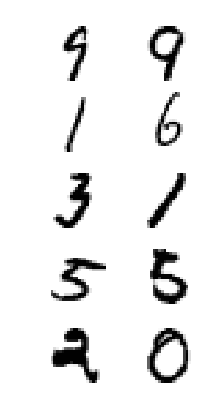

In [78]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.figure(figsize=(3, 3 * batch_size))
plt.subplot(121)
plt.imshow(X_batch[:,0].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.subplot(122)
plt.imshow(X_batch[:,1].reshape(28 * batch_size, 28), cmap="binary", interpolation="nearest")
plt.axis('off')
plt.show()

In [79]:
y_batch

array([[1],
       [0],
       [0],
       [1],
       [0]])

In [80]:
# c)
# train DNN on this training set. feed each pair to both DNN A and DNN B

# Generate test set
X_test1, y_test1 = generate_batch(X_test, y_test, batch_size=len(X_test))

# Train the model

n_epochs = 100
batch_size = 500

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(len(X_train1) // batch_size):
            X_batch, y_batch = generate_batch(X_train1, y_train1, batch_size)
            loss_val, _ = sess.run([loss, training_op], feed_dict={X: X_batch, y: y_batch})
        print(epoch, "Train loss:", loss_val)
        if epoch % 5 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test1, y: y_test1})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_digit_comparison_model.ckpt")



0 Train loss: 0.69236004
0 Test accuracy: 0.5031
1 Train loss: 0.6937517
2 Train loss: 0.6889615
3 Train loss: 0.6279488
4 Train loss: 0.52220035
5 Train loss: 0.5394396
5 Test accuracy: 0.7317
6 Train loss: 0.5403051
7 Train loss: 0.45393974
8 Train loss: 0.4506487
9 Train loss: 0.46825847
10 Train loss: 0.35033745
10 Test accuracy: 0.8226
11 Train loss: 0.41334057
12 Train loss: 0.3694389
13 Train loss: 0.37615344
14 Train loss: 0.32001552
15 Train loss: 0.32761735
15 Test accuracy: 0.8599
16 Train loss: 0.3154365
17 Train loss: 0.3408298
18 Train loss: 0.2899377
19 Train loss: 0.3072752
20 Train loss: 0.3542515
20 Test accuracy: 0.8762
21 Train loss: 0.23173122
22 Train loss: 0.29069823
23 Train loss: 0.24736324
24 Train loss: 0.2669435
25 Train loss: 0.2391796
25 Test accuracy: 0.8854
26 Train loss: 0.25618118
27 Train loss: 0.30616865
28 Train loss: 0.26199123
29 Train loss: 0.25882086
30 Train loss: 0.26606962
30 Test accuracy: 0.8996
31 Train loss: 0.26256472
32 Train loss: 0.23

In [81]:
# d)
# Create a new DNN by reusing and freezing hidden layers of DNN A by adding a softmax output layer on top w/ 10 neurons. Train on split 2,
# and see how it works out.

reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")
frozen_outputs = tf.stop_gradient(dnn_outputs)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()

In [82]:
# Now train!

n_epochs = 100
batch_size = 50

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "./my_digit_comparison_model.ckpt")

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./my_digit_comparison_model.ckpt
0 Test accuracy: 0.9308
10 Test accuracy: 0.9595
20 Test accuracy: 0.9628
30 Test accuracy: 0.9632
40 Test accuracy: 0.963
50 Test accuracy: 0.963
60 Test accuracy: 0.9632
70 Test accuracy: 0.9632
80 Test accuracy: 0.9632
90 Test accuracy: 0.9633


In [83]:
# Compare this result with with the same DNN trained from scratch:



reset_graph()

n_inputs = 28 * 28  # MNIST
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

dnn_outputs = dnn(X, name="DNN_A")

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init)
Y_proba = tf.nn.softmax(logits)

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.MomentumOptimizer(learning_rate, momentum, use_nesterov=True)
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

dnn_A_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="DNN_A")
restore_saver = tf.train.Saver(var_list={var.op.name: var for var in dnn_A_vars})
saver = tf.train.Saver()



In [84]:
n_epochs = 150
batch_size = 50

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train2))
        for rnd_indices in np.array_split(rnd_idx, len(X_train2) // batch_size):
            X_batch, y_batch = X_train2[rnd_indices], y_train2[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 10 == 0:
            acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
            print(epoch, "Test accuracy:", acc_test)

    save_path = saver.save(sess, "./my_mnist_model_final.ckpt")

0 Test accuracy: 0.8623
10 Test accuracy: 0.9184
20 Test accuracy: 0.9379
30 Test accuracy: 0.9403
40 Test accuracy: 0.9406
50 Test accuracy: 0.9403
60 Test accuracy: 0.9401
70 Test accuracy: 0.9402
80 Test accuracy: 0.94
90 Test accuracy: 0.9402
100 Test accuracy: 0.9402
110 Test accuracy: 0.9399
120 Test accuracy: 0.9396
130 Test accuracy: 0.9398
140 Test accuracy: 0.9396
